In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, Plots, PhasorNetworks

In [3]:
using Lux, NNlib, Zygote, ComponentArrays, Optimisers

In [5]:
using Random: Xoshiro

In [6]:
phases = -1.0:0.1:1.0 |> collect
n_in = length(phases)

21

In [7]:
sa = SpikingArgs()
train = phase_to_train(phases, spk_args=sa, repeats=1)

Spike Train: (21,) with 21 spikes.

In [8]:
using PhasorNetworks: gaussian_kernel

In [9]:
function cfn(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)

    #add currents into the active synapses
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = current_kernel(train.times)

    return impulses
end

cfn (generic function with 1 method)

In [10]:
cfn(train, 0.5, sa)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [11]:
current_fn = t -> cfn(train, t, sa)

#4 (generic function with 1 method)

In [22]:
ts = 0.0:0.001:1.0
current_sample = stack(current_fn.(ts), dims=1);

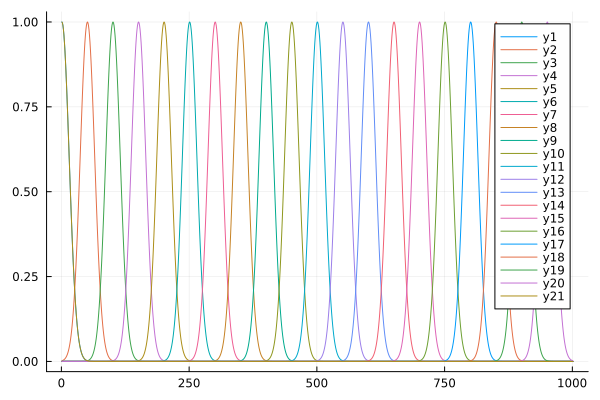

In [23]:
plot(current_sample)

In [24]:
size(current_sample)

(1001, 21)

In [54]:
function interpolate_2D(t::Real, times::Vector{<:Real}, values::AbstractMatrix{<:Real})
    n_steps, n_vals = size(values)
    #extrapolate to zeros
    if t <= times[1] || t >= times[end]
        return zeros((n_vals),)
    else
        i_next = findfirst(times .> t)
        i_prev = i_next - 1

        t_next = times[i_next]
        t_prev = times[i_prev]
        proportion = (t - t_prev) / (t_next - t_prev)

        mixture = proportion .* values[i_next,:] .+ (1 - proportion) .* values[i_prev,:]
        return mixture
    end
end



interpolate_2D (generic function with 1 method)

In [55]:
interpolate_2D(0.5, collect(ts), current_sample)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [56]:
ifn_linear = t -> interpolate_2D(t, collect(ts), current_sample)

#12 (generic function with 1 method)

In [57]:
ifn_linear(0.5)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [59]:
current_sample2 = stack([ifn_linear(t) for t in ts], dims=1);

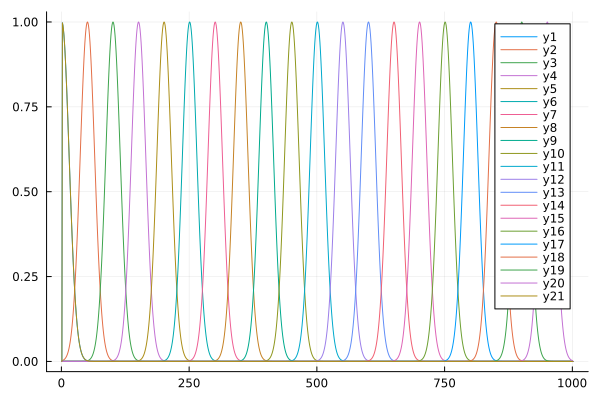

In [60]:
plot(current_sample2)

In [61]:
ode_fn = Chain(Dense(n_in => n_in))

Dense(21 => 21)     # 462 parameters

In [62]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [63]:
in_ps, in_st = Lux.setup(rng, ode_fn)

((weight = Float32[-0.034407683 0.033833884 … -0.24778546 0.29199758; -0.24675442 -0.34743497 … 0.120002545 0.33507735; … ; -0.30658105 0.07079895 … -0.060400184 -0.31799373; 0.071049556 0.102035664 … -0.22994705 -0.15559468], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), NamedTuple())

In [68]:
smp = ifn_linear(0.01);

In [69]:
size(smp)

(21,)

In [70]:
smp1, _ = ode_fn(smp, in_ps, in_st)

([0.20123090445609673, 0.06242246827681089, -0.10408152741785504, -0.2772588268055871, 0.2346992688749323, -0.29754464372904965, 0.07604089496146973, 0.04619681094634273, -0.4118005747786163, -0.21607120972877814  …  0.016028747493214535, 0.08021493579394642, 0.06744148855043243, -0.022178292382605297, 0.09895924125318165, -0.14149898891574283, 0.007136197697021229, -0.024438573964248977, -0.4851226006350068, -0.06397495731879438], NamedTuple())

In [71]:
smp1 |> size

(21,)

In [72]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)),)

Chain(
    layer_1 = PhasorODE(
        model = Dense(21 => 21),        # 462 parameters
    ),
    layer_2 = WrappedFunction(#18),
)         # Total: 462 parameters,
          #        plus 0 states.

In [73]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[-0.2151638 0.3665407 … -0.23877338 -0.087368436; -0.36821428 -0.24055284 … 0.24381015 0.31122464; … ; 0.21464978 -0.055422254 … 0.2479661 0.15970698; -0.10953547 0.29423267 … 0.2114452 -0.12547596], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [74]:
out1, st1 = ode_model(ifn_linear, ps, st)

(Float32[0.14562933; 0.6688051; … ; 0.08914208; -0.799682;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [75]:
u1 = Array(out1)

21×1 Matrix{Float32}:
  0.14562933
  0.6688051
  0.5978892
 -0.94405097
  0.28298724
  0.58040893
  0.8769533
  0.6957139
  0.42770156
 -0.6288734
  0.23711944
 -0.11868122
 -0.6359396
 -0.66641
  0.34502465
  0.44600406
  0.5148561
  0.30541044
 -0.54775125
  0.08914208
 -0.799682

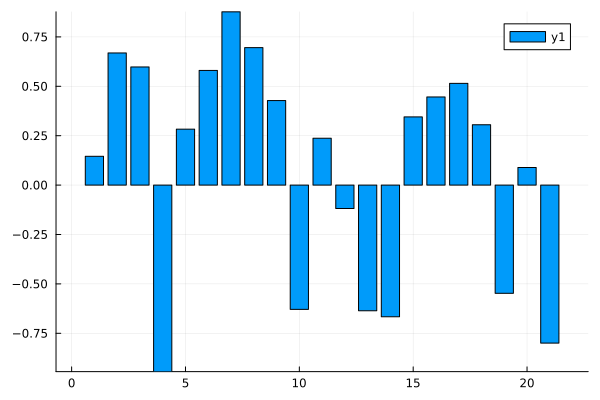

In [76]:
bar(u1)

In [77]:
#calc a gradient through a loss fn on the network

In [78]:
using Statistics: mean

In [99]:
function test_loss(x, ps, st)
    i_fn = t -> interpolate_2D(t, collect(ts), current_sample)
    p0, _ = ode_model(i_fn, ps, st)
    err = mean(similarity_loss(p0, reshape(phases, (:,1)),1))
    return err
end

test_loss (generic function with 1 method)

In [111]:
test_loss(current_sample, ps, st)

1.0895886899010865

In [112]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.2151638 0.3665407 … -0.23877338 -0.087368436; -0.36821428 -0.24055284 … 0.24381015 0.31122464; … ; 0.21464978 -0.055422254 … 0.2479661 0.15970698; -0.10953547 0.29423267 … 0.2114452 -0.12547596], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = Float32[])

In [113]:
grads = Zygote.gradient(p -> test_loss(current_sample, p, st), psa)

((layer_1 = (weight = Float32[-0.0008790011 0.016500328 … 0.004053439 -0.0008790011; -0.0022195333 0.009679362 … 0.017075544 -0.0022195333; … ; -0.00019401347 0.011845419 … -0.00085971644 -0.00019401347; -0.0037552833 0.048149183 … 0.02209565 -0.0037552833], bias = Float32[-0.020638315; 0.0076880027; … ; -0.01989288; -0.046396006;;]), layer_2 = Float32[]),)

In [114]:
withgradient(p -> test_loss(current_sample, p, st), psa)

(val = 1.0686038820043968, grad = ((layer_1 = (weight = Float32[-0.0008790011 0.016500328 … 0.004053439 -0.0008790011; -0.0022195333 0.009679362 … 0.017075544 -0.0022195333; … ; -0.00019401347 0.011845419 … -0.00085971644 -0.00019401347; -0.0037552833 0.048149183 … 0.02209565 -0.0037552833], bias = Float32[-0.020638315; 0.0076880027; … ; -0.01989288; -0.046396006;;]), layer_2 = Float32[]),))

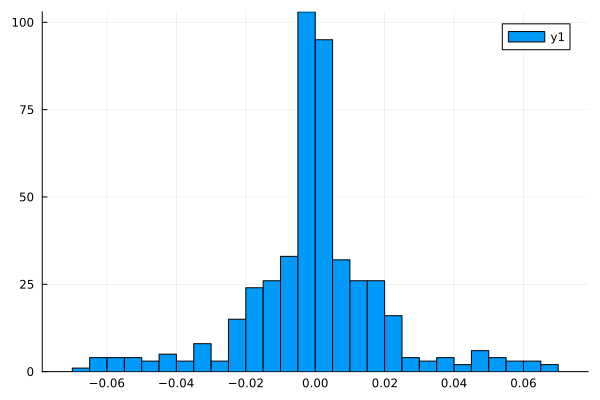

In [115]:
histogram(grads[1])

In [116]:
opt_state = Optimisers.setup(Adam(3e-4), psa)

Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))

In [117]:
losses = []

Any[]

In [119]:
for i in 1:100
    lossval, gs = withgradient(p -> test_loss(current_sample, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

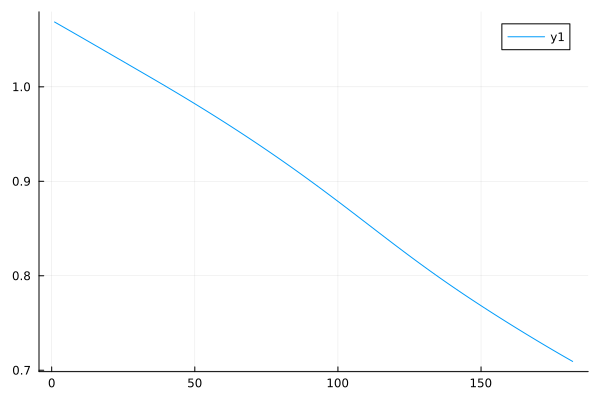

In [120]:
plot(losses)

In [121]:
for i in 1:1000
    lossval, gs = withgradient(p -> test_loss(current_sample, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

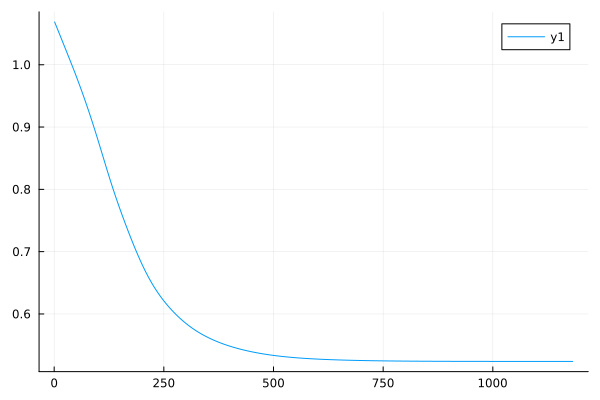

In [122]:
plot(losses)

In [123]:
test_loss(ode_model, psa, st)

5.083903100500109e-6

In [124]:
out2, _ = ode_model(current_fn, psa, st)

(Float32[0.99999535; -0.89972776; … ; 0.8962799; 0.9999874;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

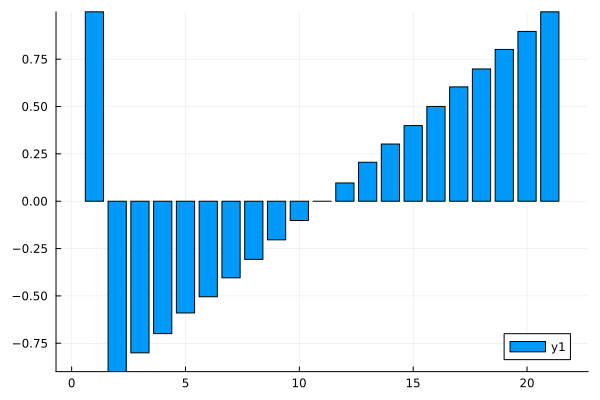

In [125]:
bar(out2)

In [126]:
similarity(vec(out2), phases)

1-element Vector{Float64}:
 0.9999300340429429